# Killer Shrimp




Our objective is to predict whether locations contain killer shrimp (Dikerogammarus villosus) based upon environmental data including temperature, salinity, depth, exposure, and substrate.

The solution with the score of 0.99938.

We will first fill in missing data by using sklearn's IterativeImputer. We will then perform feature engineering to create several new features including an outlier (bounded box) feature and EUNIS exposure/energy subclasses. Using these new features we will create an XGBoost model to make predictions on our test set. Finally, we will look at the feature importances of our model to see which features contribute the most to our model.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from xgboost import XGBClassifier
from xgboost import plot_importance


In the next cell we will set a few global variables. The data_dir is where we are storing our input data (training and test data). The random state is used throughout to remove the randomness of some algorithms, it will allow us to reproduce our results.

In [7]:
# Global variables
dir = 'D:\Phoenix/'
random_state = 0

With the previously defined data_dir, we can now import our training and test data. We will also split the data into X (features), Y (target variable), and IDs.

In [8]:
# Import data
train = pd.read_csv(dir + 'train.csv')
test = pd.read_csv(dir + 'test.csv')

# Split data into different variables
Y_train = train['Presence']
ID_train = train['pointid']
X_train = train.drop(['Presence', 'pointid'], axis = 1)
ID_test = test['pointid']
X_test = test.drop(['pointid'], axis = 1)

**Fill In Missing Data**

An EDA of the dataset would show that there is a lot of missing data. Also gives a way for imputing values for this missing data - using the sklearn IterativeImputer. In this notebook we will use the same as it performs better than more simple methods such as filling in with the mean or median.

In [33]:
# Fill in NaN values using sklearn imputer
imputer = IterativeImputer(max_iter = 10, random_state = random_state)
imputer.fit(X_train)
column_names = list(X_train.columns)
X_train = pd.DataFrame(imputer.transform(X_train), columns = column_names)
X_test = pd.DataFrame(imputer.transform(X_test), columns = column_names)

# Feature Engineering
We only have five features in the training data (temperature, salinity, depth, exposure, and substrate).  We will use feature engineering to create more features. Those used in this notebook are:
 - Ocean Density
 - EUNIS Exposure Classifications (for which we actually create nine features)
 - Temperature Equation
 - Outlier (Bounded-Box)

In [9]:
# If you notice any errors with this function please let me know as it was transcribed by hand from the linked source
def sea(temp, salin, depth):
    # Get approximate pressure at given depth
    Pressure = 1 + (depth / 10)
    
    # Standard Mean Ocean Water density
    smow = 999.842594 + (6.793953e-2 * temp) - (9.095290e-3 * (temp ** 2)) + (1.001685e-4 * (temp ** 3)) - (1.120083e-6 * (temp ** 4)) + (6.536332e-9 * (temp ** 5))
    
    # Sea water density at normal atmospheric pressure
    B = 0.82449 - (4.0899e-3 * temp) + (7.6438e-5 * (temp ** 2)) - (8.2467e-7 * (temp ** 3)) + (5.3875e-9 * (temp ** 4))
    C = -5.7246e-3 + (1.0227e-4 * temp) + (-1.6546e-6 * (temp ** 2))
    D = 4.8314e-4
    Density = smow + (B * salin) + (C * (salin ** 1.5)) + (D * (salin ** 2))
    
    # Determination of compression module at pressure 0
    Kw = 19652.21 + (148.4206 * temp) + (-2.327105 * (temp ** 2)) + (1.360477e-2 * (temp ** 3)) + (-5.155288e-5 * (temp ** 4))
    F = 54.6746 + (-0.603459 * temp) + (1.099870e-2 * (temp ** 2)) + (-6.167e-5 * (temp ** 3))
    G = 7.9440e-2 + (1.6483e-2 * temp) + (-5.3009e-4 * (temp ** 2))
    K_0 = Kw + (F * salin) + (G * (salin ** 1.5))
    
    # Determination of final compressibility module
    Aw = 3.23990 + (1.43713e-3 * temp) + (1.16092e-4 * (temp ** 2)) + (-5.77905e-7 * (temp ** 3))
    A1 = Aw + ((2.28380e-3 + (-1.09810e-5 * temp) + (-1.60780e-6 * (temp ** 2))) * salin) + (1.91075e-4 * (salin ** 1.5))
    Bw = 8.50935e-5 + (-6.12293e-6 * temp) + (5.27870e-8 * (temp ** 2))
    B2 = Bw + (-9.9348e-7 + (2.0816e-8 * temp) + (9.1697e-10 * (temp ** 2))) * salin
    K = K_0 + (A1 * Pressure) + (B2 * (Pressure ** 2))
    
    return (Density / (1 - (Pressure / K))) - 1000

In [10]:
X_train['Density'] = X_train.apply(lambda x: sea(x['Temperature_today'], x['Salinity_today'], x['Depth']), axis = 1)
X_test['Density'] = X_test.apply(lambda x: sea(x['Temperature_today'], x['Salinity_today'], x['Depth']), axis = 1)

## EUNIS Exposure Classifications


| EUNIS Subclass | SWM Minimum | SWM Maxium |
| --- | --- | --- |
| Extremely Exposed | 2000000 | 5000000 |
| Very Exposed | 1000000 | 2000000 |
| Exposed | 500000 | 1000000 |
| Moderately Exposed | 100000 | 500000 |
| Sheltered | 10000 | 100000 |
| Very Sheltered | 4000 | 10000 |
| Extremely Sheltered | 1200 | 4000 |
| Ultra Sheltered | 1 | 1200 |



In [11]:
def sort(exposure):
    if exposure <= 1200:
        return 'Ultra Sheltered'
    elif exposure <= 4000:
        return 'Extremely Sheltered'
    elif exposure <= 10000:
        return 'Very Sheltered'
    elif exposure <= 100000:
        return 'Sheltered'
    elif exposure <= 500000:
        return 'Moderately Exposed'
    elif exposure <= 1000000:
        return 'Exposed'
    elif exposure <= 2000000:
        return 'Very Exposed'
    else:
        return 'Extremely Exposed'

In [12]:
for classifi in ['Ultra Sheltered', 'Extremely Sheltered', 'Very Sheltered', 'Sheltered', 'Moderately Exposed', 'Exposed', 'Very Exposed']:
    X_train['EUNIS ' + classifi] = X_train['Exposure'].apply(lambda x: 1 if sort(x) == classifi else 0)
    X_test['EUNIS ' + classifi] = X_test['Exposure'].apply(lambda x: 1 if sort(x) == classifi else 0)

X_train['EUNIS Min Very Exposed'] = X_train['Exposure'].apply(lambda x: 1 if sort(x) == 'Extremely Exposed' or sort(x) == 'Very Exposed' else 0)
X_test['EUNIS Min Very Exposed'] = X_test['Exposure'].apply(lambda x: 1 if sort(x) == 'Extremely Exposed' or sort(x) == 'Very Exposed' else 0)

## Temperature-Only Model Equation


$$ p(Shrimp) = \frac{1}{1 + e^{-f(t)}}$$  

$$ f(t) = -10.52910058 + 2.21529641*t - 0.57623745*t^2 - 2.06832485*t^3\\ + 0.30713969*t^4 - 2.21781761*t^5 - 1.85363275*t^6$$

In [13]:
def Temp(t):
    coefs = [-10.52910058, 2.21529641, -0.57623745, -2.06832485, 0.30713969, -2.21781761, -1.85363275]
    temps = [1, t, t**2, t**3, t**4, t**5, t**6]
    summed = np.dot(coefs, temps)
    return 1 / (1 + np.exp(summed))

In [14]:
X_train['Temperature Model'] = X_train['Temperature_today'].apply(lambda x: Temp(x))
X_test['Temperature Model'] = X_test['Temperature_today'].apply(lambda x: Temp(x))

In [15]:
# Wrapper to remove outliers
class Outlier():
    def __init__(self, ratio, outlier_trait):
        self.ratio = ratio
        self.outlier_trait = outlier_trait
    
    def exclude_outliers(self, row):
        lower_multiplier = self.ratio
        upper_multiplier = 1 / self.ratio
        conditions = []
        for feature, cmin, cmax in self.outlier_conditions:
            conditions.append(row[feature] > cmin)
            conditions.append(row[feature] < cmax)
        return 1 if sum(conditions) == len(conditions) else 0
    
    def fit(self, x, y):
        self.outlier_conditions = []
        for feature in self.outlier_trait:
            fmin = x[y == 1][feature].min()
            fmax = x[y == 1][feature].max()
            lower_multiplier = self.ratio
            upper_multiplier = 1 / self.ratio
            
            cmin = fmin * lower_multiplier if fmin > 0 else fmin * upper_multiplier
            cmax = fmax * upper_multiplier if fmax > 0 else fmax * lower_multiplier
            self.outlier_conditions.append((feature, cmin, cmax))
    
    def transform(self, x):
        outliers = x.apply(lambda x: self.exclude_outliers(x), axis = 1)
        return outliers
outlier_finder = Outlier(0.82, ['Temperature_today', 'Salinity_today', 'Exposure', 'Depth'])
outlier_finder.fit(X_train, Y_train)
X_train['Outlier'] = outlier_finder.transform(X_train)
X_test['Outlier'] = outlier_finder.transform(X_test)

# Models
Firstly we will define a function that allows us the perform stratified cross validation. We will be using five folds. Setting verbose to True will output the AUROC score for each fold as well as the final average. The final average is also returned from the function.

In [13]:
# K-Fold Cross Validation
def five_fold_cv(model, X_train, Y_train, verbose = True):
    skf = StratifiedKFold(n_splits = 5)
    fold = 1
    scores = []
    
    for train_index, test_index in skf.split(X_train, Y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        Y_train_fold, Y_test_fold = Y_train.iloc[train_index], Y_train.iloc[test_index]

        model.fit(X_train_fold, Y_train_fold)

        preds = model.predict_proba(X_test_fold)
        preds = [x[1] for x in preds]

        score = roc_auc_score(Y_test_fold, preds)
        scores.append(score)
        if verbose:
            print('Fold', fold, '     ', score)
        fold += 1
    
    avg = np.mean(scores)
    if verbose:
        print()
        print('Average:', avg)
    return avg

We will also define a list of features that will be used in the model.

In [14]:
trait = ['Temperature_today', 'Salinity_today', 'Depth', 'EUNIS Ultra Sheltered', 'EUNIS Extremely Sheltered', 'EUNIS Very Sheltered', 'EUNIS Sheltered', 'EUNIS Moderately Exposed', 'EUNIS Exposed', 'EUNIS Very Exposed', 'Substrate', 'Outlier', 'Temperature Model', 'Density', 'EUNIS Min Very Exposed']

Now we will create an XGB model and check its performance by doing cross validation. The specific model we are creating actually scores 0.99984 on the public leaderboard, the cross validation score is slightly below this but still high.

In [15]:
model = XGBClassifier(random_state = random_state, eval_metric = 'auc', objective = 'binary:logistic',
                          learning_rate = 0.3, max_depth = 5, subsample = 1, reg_lambda = 0.5)

score = five_fold_cv(model, X_train[trait], Y_train, verbose=True)

Fold 1       0.9993509127016618
Fold 2       0.9957776956924899
Fold 3       0.9986403249054168
Fold 4       0.999330539471705
Fold 5       0.9993685238709973

Average: 0.998493599328454


# Predictions
With our model created we can now make predictions. Our predictions will be outputted to _preds.csv_.

In [34]:
preds = pd.DataFrame(ID_test, columns=['pointid'])

model.fit(X_train[trait], Y_train)
preds['Presence'] = model.predict_proba(X_test[trait])[:,1]

preds[['pointid', 'Presence']].to_csv(r'D:\Phoenix\output.csv', index=False)

PermissionError: [Errno 13] Permission denied: 'D:\\Phoenix\\output.csv'

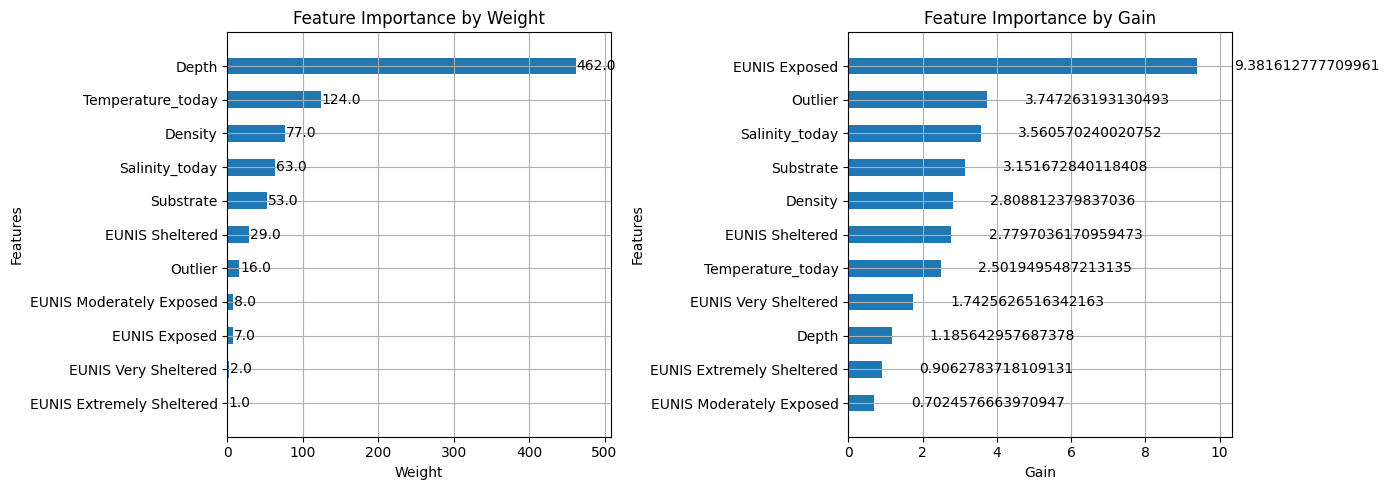

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
plot_importance(model, importance_type='weight', height=0.5, xlabel='Weight', title='Feature Importance by Weight', ax=ax1)
plot_importance(model, importance_type='gain', height=0.5, xlabel='Gain', title='Feature Importance by Gain', ax=ax2)
plt.tight_layout()
plt.show()